In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load your dataset into a Pandas DataFrame (replace 'your_dataset.csv' with your file)
df_encoded = pd.read_excel(r'C:\Users\Shardul\OneDrive - London Business School\coding\anya\data\ppie-cleaned-v3.xlsx')

# df_encoded = pd.read_excel(r'/content/ppie-cleaned-v2.xlsx')

In [3]:
order_list_yessometimes = ["Yes","Yes, sometimes", "No", "Not applicable", "Don't know/can't remember"]

order_list_likert =  ["Strongly Disagree", "Disagree", "Neutral", "Agree", "Strongly Agree", "Other"]

order_list_likert_num = ['5','4','3','2','1']

# order_list_yespartly = ["Yes","Yes, partly", "No", "Not applicable", "Don't know/can't remember"]

# Replace infinite values with NaN in your DataFrame
df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True) 

# Filter the DataFrame
df_filtered = df_encoded[df_encoded['anya_user'] == 1]

In [4]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# List of free text columns
free_text_columns = [
    'anc_additional_challenges_experiences',
    'anc_antenatal_access_issues',
    'non_breastfeeding_reason',
    'pnc_additional_experiences',
    'demo_additional_maternity_experience'
]



'anc_additional_challenges_experiences': """Difficulty taking time off work for appointments (due to inflexible schedules, being self-employed, etc.)
Travel and distance to appointments (appointments far from home, in different towns, public transport issues, etc.)
Parking difficulties at hospitals (limited spaces, difficulty finding spaces, etc.)
Childcare challenges (appointments during work hours, difficulty entertaining other children during appointments, etc.)
Appointment scheduling and availability (inflexible appointment days, difficulty booking appointments, cancellations by midwives, etc.)
Some mentioned positive experiences (easy to access appointments, appointments close to home, flexible work arrangements, etc.)"""


    'anc_antenatal_access_issues',
    'non_breastfeeding_reason',
    'pnc_additional_experiences',
    'demo_additional_maternity_experience'



# Variations of NaN values to replace
nan_variations = ["'nan", "'na", "'n/a", "'none", "'.", "'"]

# Function to replace NaN variations with None
def replace_nan_na(text):
    if isinstance(text, str):
        if text.strip().lower() in nan_variations:
            return None
    return text

for column in free_text_columns:
    df_encoded[column] = df_encoded[column].apply(replace_nan_na)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shardul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shardul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shardul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Function to clean text
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.split()
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)


for column in free_text_columns:
    df_encoded[column] = df_encoded[column].apply(clean_text)

In [6]:
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    if text is None:
        return []
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

for column in free_text_columns:
    df_encoded[f'{column}_tokens'] = df_encoded[column].apply(tokenize_and_lemmatize)


In [7]:
def get_word_frequencies(column):
    all_words = [word for text in df_encoded[column] for word in word_tokenize(text)]
    return Counter(all_words)

for column in free_text_columns:
    word_freq = get_word_frequencies(column)
    print(f"Top words in {column}:")
    print(word_freq.most_common(10))

Top words in anc_additional_challenges_experiences:
[('na', 50), ('none', 30), ('pregnancy', 25), ('birth', 23), ('’', 14), ('like', 12), ('baby', 12), ('care', 11), ('felt', 11), ('midwife', 10)]
Top words in anc_antenatal_access_issues:
[('easy', 69), ('appointments', 34), ('na', 26), ('work', 16), ('hospital', 16), ('drive', 15), ('’', 15), ('difficult', 12), ('time', 12), ('t', 12)]
Top words in non_breastfeeding_reason:
[('baby', 11), ('enough', 9), ('wasnt', 6), ('well', 6), ('breastfeed', 6), ('couldnt', 5), ('get', 5), ('latch', 5), ('didn', 3), ('’', 3)]
Top words in pnc_additional_experiences:
[('na', 56), ('none', 35), ('baby', 26), ('’', 15), ('support', 15), ('health', 14), ('would', 10), ('hospital', 10), ('breastfeeding', 10), ('t', 9)]
Top words in demo_additional_maternity_experience:
[('care', 14), ('na', 11), ('hospital', 10), ('baby', 8), ('experience', 7), ('birth', 7), ('days', 7), ('time', 6), ('’', 6), ('breastfeeding', 6)]


In [8]:
def analyze_sentiment(text):
    if text is None:
        return 0
    return TextBlob(text).sentiment.polarity

for column in free_text_columns:
    df_encoded[f'{column}_sentiment'] = df_encoded[column].apply(analyze_sentiment)

#print(df_encoded[[column for column in df_encoded.columns if 'sentiment' in column]])

def topic_modeling(column, n_topics=5, n_top_words=10):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df_encoded[column])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"Topics in {column}:")
    for index, topic in enumerate(lda.components_):
        print(f"\nTopic {index + 1}:")
        for i in topic.argsort()[-n_top_words:]:
            print(f"{feature_names[i]} ({topic[i]:.2f})")
    
    # Print document-topic distribution
    doc_topic_distribution = lda.transform(dtm)
    #print(f"\nDocument-Topic Distribution for {column}:")
    #print(doc_topic_distribution)

    return lda, vectorizer

for column in free_text_columns:
    lda, vectorizer = topic_modeling(column, n_topics=5, n_top_words=10)


Topics in anc_additional_challenges_experiences:

Topic 1:
really (1.20)
scans (1.20)
space (1.20)
parents (1.20)
illness (1.20)
little (1.21)
mental (1.47)
partner (2.20)
applicable (2.20)
na (50.20)

Topic 2:
didnt (3.96)
worried (3.96)
lack (4.20)
feel (4.20)
home (4.20)
like (4.20)
midwife (5.21)
baby (6.21)
care (9.20)
birth (13.89)

Topic 3:
experienced (2.20)
mental (2.20)
consultant (2.20)
previous (2.20)
wanted (2.21)
access (3.20)
anxiety (4.20)
help (4.21)
breastfeeding (5.23)
pregnancy (9.22)

Topic 4:
time (4.19)
bmi (4.20)
weeks (4.20)
lot (4.20)
information (5.20)
support (7.20)
like (7.20)
felt (8.20)
birth (8.45)
pregnancy (12.96)

Topic 5:
csection (3.20)
area (3.20)
felt (3.20)
midwives (3.20)
wrong (3.20)
baby (3.21)
information (4.20)
given (4.20)
health (4.20)
hospital (4.21)
Topics in anc_antenatal_access_issues:

Topic 1:
home (2.20)
gp (2.21)
close (3.20)
hard (4.20)
quite (4.20)
hospital (4.20)
attend (4.20)
childcare (4.21)
appointment (6.20)
easy (8.29)

Top

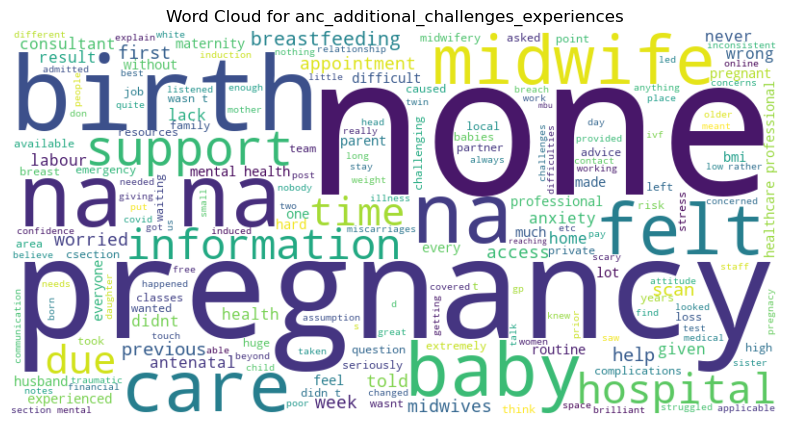

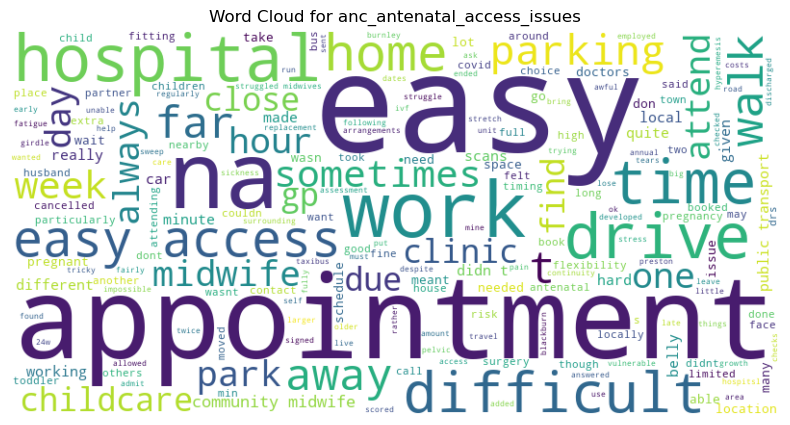

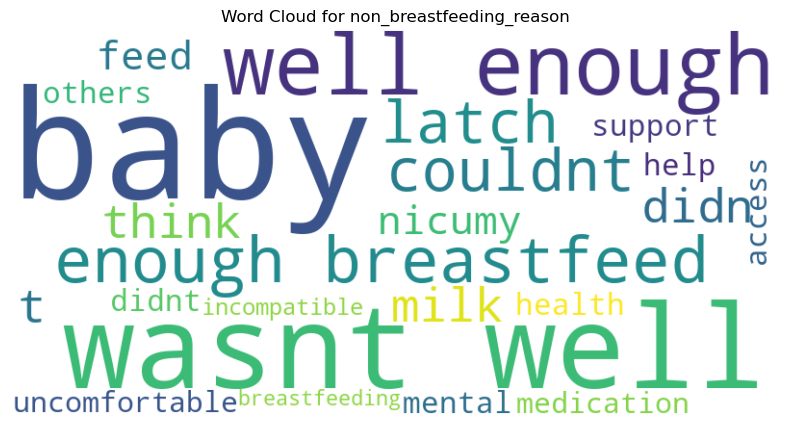

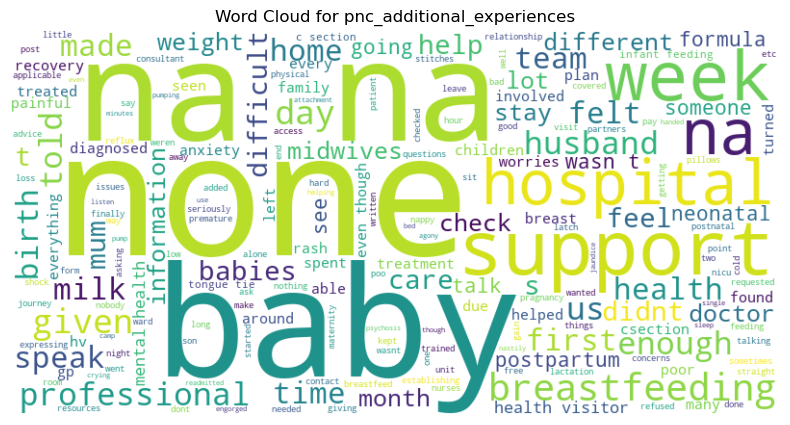

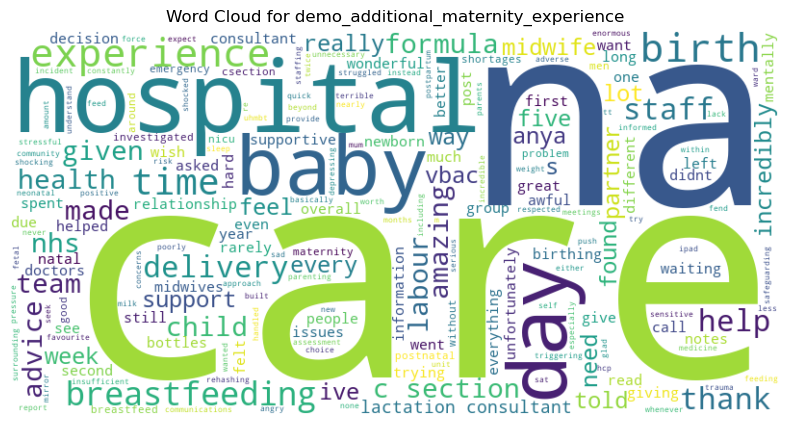

In [9]:
def generate_word_cloud(column):
    all_words = ' '.join(df_encoded[column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {column}")
    plt.show()

for column in free_text_columns:
    generate_word_cloud(column)